In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# If xgboost is available:
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)

RANDOM_STATE = 42


In [6]:
train = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
transactions = pd.read_csv("transactions.csv")
holidays = pd.read_csv("holidays_events.csv")

print("Train shape:", train.shape)
train.head()

Train shape: (3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [7]:
# %% [markdown]
# ## 3. Basic Preprocessing & Merging
# - Convert `date` to datetime  
# - Merge store, oil, transactions, holidays into a single dataframe  
# - Handle missing values (especially in oil prices)

# %%
# Convert dates
train["date"] = pd.to_datetime(train["date"])
oil["date"] = pd.to_datetime(oil["date"])
transactions["date"] = pd.to_datetime(transactions["date"])
holidays["date"] = pd.to_datetime(holidays["date"])

# Aggregate holidays to date level (many categories; here we just keep a simple flag)
holiday_flags = (
    holidays[holidays["transferred"] == False]  # ignore transferred holidays for now
    .groupby("date")
    .size()
    .rename("holiday_count")
    .reset_index()
)

# Merge everything
df = train.merge(stores, on="store_nbr", how="left")
df = df.merge(oil, on="date", how="left")
df = df.merge(transactions, on=["date", "store_nbr"], how="left")
df = df.merge(holiday_flags, on="date", how="left")

# Fill missing values
df["dcoilwtico"] = df["dcoilwtico"].interpolate().bfill().ffill()
df["transactions"] = df["transactions"].fillna(0)
df["holiday_count"] = df["holiday_count"].fillna(0)

df.head()



,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,holiday_count
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,1.0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,1.0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,0.0,1.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,0.0,1.0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,0.0,1.0


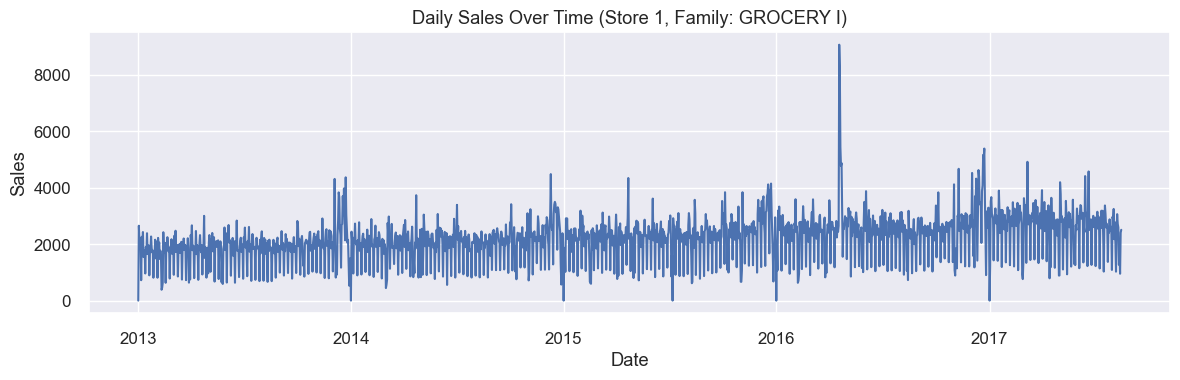

In [8]:
# %%
# Choose one example: Store 1, Family "GROCERY I" (you can change this)
example_store = 1
example_family = "GROCERY I"

example = df[(df["store_nbr"] == example_store) & (df["family"] == example_family)].copy()
example = example.sort_values("date")

plt.figure(figsize=(12,4))
plt.plot(example["date"], example["sales"])
plt.title(f"Daily Sales Over Time (Store {example_store}, Family: {example_family})")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

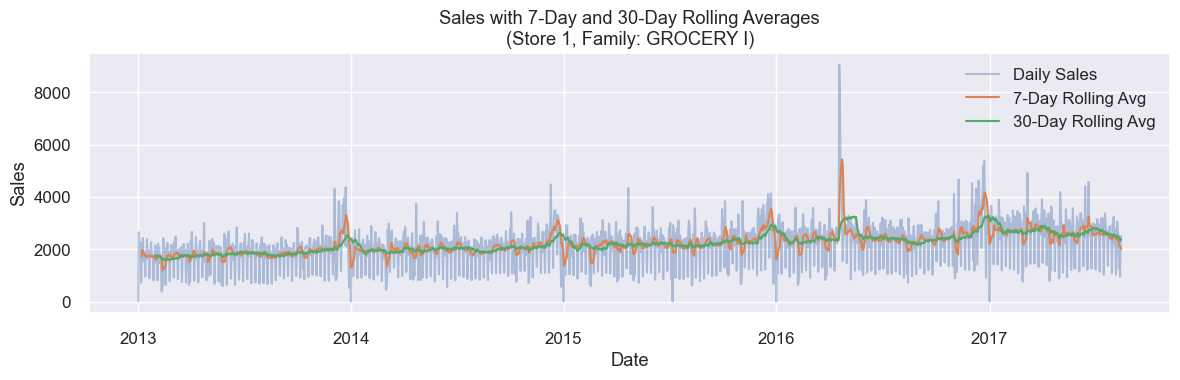

In [9]:
# %%
# Add rolling averages for visualization
example["rolling_7"] = example["sales"].rolling(7).mean()
example["rolling_30"] = example["sales"].rolling(30).mean()

plt.figure(figsize=(12,4))
plt.plot(example["date"], example["sales"], alpha=0.4, label="Daily Sales")
plt.plot(example["date"], example["rolling_7"], label="7-Day Rolling Avg")
plt.plot(example["date"], example["rolling_30"], label="30-Day Rolling Avg")
plt.title(f"Sales with 7-Day and 30-Day Rolling Averages\n(Store {example_store}, Family: {example_family})")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

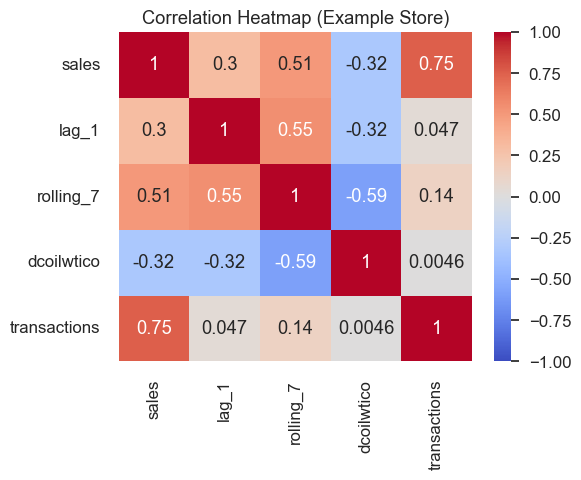

In [10]:
# %%
# Simple feature engineering for correlation plot (on the example subset)
example["lag_1"] = example["sales"].shift(1)
example["rolling_7"] = example["sales"].rolling(7).mean()

corr_cols = ["sales", "lag_1", "rolling_7", "dcoilwtico", "transactions"]
corr_mat = example[corr_cols].dropna().corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_mat, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap (Example Store)")
plt.tight_layout()
plt.show()

In [11]:
# %% [markdown]
# ## 5. Feature Engineering
# For the full dataset, we now create:
# - Date features: year, month, dayofweek, etc.
# - Lags: 1-day, 7-day, 14-day
# - Rolling means: 7-day, 30-day
#
# All features are computed **within each (store_nbr, family)** group to avoid leakage.

# %%
df = df.sort_values(["store_nbr", "family", "date"])

# Date features
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["dayofweek"] = df["date"].dt.dayofweek
df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)


# Lag features
group_cols = ["store_nbr", "family"]
df["lag_1"] = df.groupby(group_cols)["sales"].shift(1)
df["lag_7"] = df.groupby(group_cols)["sales"].shift(7)
df["lag_14"] = df.groupby(group_cols)["sales"].shift(14)

# Rolling features
df["rolling_7"] = df.groupby(group_cols)["sales"].rolling(7).mean().reset_index(level=[0,1], drop=True)
df["rolling_30"] = df.groupby(group_cols)["sales"].rolling(30).mean().reset_index(level=[0,1], drop=True)

# Drop first few rows with NaNs from lags/rolling windows
df_fe = df.dropna(subset=["lag_14", "rolling_7", "rolling_30"]).copy()
print("After feature engineering:", df_fe.shape)
df_fe.head()

After feature engineering: (2949210, 23)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,year,month,day,dayofweek,weekofyear,lag_1,lag_7,lag_14,rolling_7,rolling_30
51678,51678,2013-01-30,1,AUTOMOTIVE,6.0,0,Quito,Pichincha,D,13,...,2013,1,30,2,5,2.0,3.0,1.0,3.142857,2.266667
53460,53460,2013-01-31,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,2013,1,31,3,5,6.0,0.0,1.0,3.142857,2.266667
55242,55242,2013-02-01,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,2013,2,1,4,5,0.0,5.0,0.0,2.857143,2.300000
57024,57024,2013-02-02,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,2013,2,2,5,5,3.0,4.0,5.0,2.285714,2.200000
58806,58806,2013-02-03,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,2013,2,3,6,5,0.0,2.0,3.0,2.000000,2.100000


In [12]:
# %% [markdown]
# ## 6. Train / Validation / Test Split (Time-Based)
# We must respect time order.  
# - Use data up to a certain date for training  
# - Later period for validation  
# - Final period for testing
#
# You can tweak the cutoffs as needed. Below is one example:

# %%
# Check date range
print(df_fe["date"].min(), "->", df_fe["date"].max())

# Example split:
train_end = "2016-12-31"
val_end = "2017-06-30"   # validation up to this date; test is after

train_mask = df_fe["date"] <= train_end
val_mask = (df_fe["date"] > train_end) & (df_fe["date"] <= val_end)
test_mask = df_fe["date"] > val_end

feature_cols = [
    "store_nbr", "onpromotion", "dcoilwtico", "transactions", "holiday_count",
    "year", "month", "day", "dayofweek", "weekofyear",
    "lag_1", "lag_7", "lag_14", "rolling_7", "rolling_30"
]
# Optional: encode 'family' as categorical codes
df_fe["family_code"] = df_fe["family"].astype("category").cat.codes
feature_cols.append("family_code")

target_col = "sales"

X_train = df_fe.loc[train_mask, feature_cols]
y_train = df_fe.loc[train_mask, target_col]

X_val = df_fe.loc[val_mask, feature_cols]
y_val = df_fe.loc[val_mask, target_col]

X_test = df_fe.loc[test_mask, feature_cols]
y_test = df_fe.loc[test_mask, target_col]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


# %% [markdown]
# ### Helper functions for metrics

# %%
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def print_metrics(model_name, y_true, y_pred):
    print(f"{model_name} – RMSE: {rmse(y_true, y_pred):.2f}, MAE: {mae(y_true, y_pred):.2f}")



2013-01-30 00:00:00 -> 2017-08-15 00:00:00
Train: (2544696, 16) Val: (322542, 16) Test: (81972, 16)


In [13]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_val_pred_lr = linreg.predict(X_val)
y_test_pred_lr = linreg.predict(X_test)

print("Baseline Linear Regression performance:")
print_metrics("Validation", y_val, y_val_pred_lr)
print_metrics("Test", y_test, y_test_pred_lr)


Baseline Linear Regression performance:
Validation – RMSE: 336.58, MAE: 93.84
Test – RMSE: 244.72, MAE: 78.23


In [14]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    min_samples_leaf=20
)

rf.fit(X_train, y_train)

y_val_pred_rf = rf.predict(X_val)
y_test_pred_rf = rf.predict(X_test)

print("Random Forest performance:")
print_metrics("Validation", y_val, y_val_pred_rf)
print_metrics("Test", y_test, y_test_pred_rf)



Random Forest performance:
Validation – RMSE: 266.93, MAE: 64.65
Test – RMSE: 199.72, MAE: 56.03


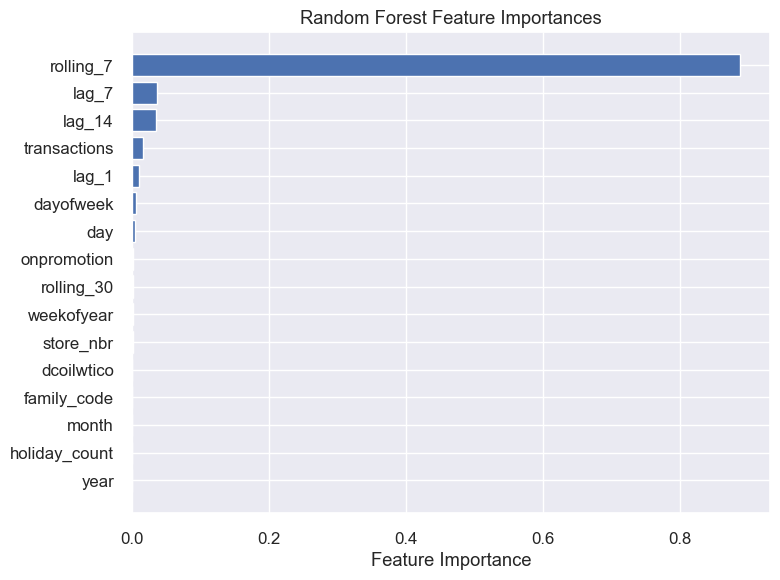

In [15]:
# --- Random Forest Feature Importance ---

import numpy as np
import matplotlib.pyplot as plt

# Get importances and sort them
rf_importances = rf.feature_importances_
indices = np.argsort(rf_importances)[::-1]  # descending

sorted_features = [feature_cols[i] for i in indices]
sorted_importances = rf_importances[indices]

plt.figure(figsize=(8, 6))
plt.barh(sorted_features[::-1], sorted_importances[::-1])  # reverse for nicest order
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


In [16]:
if XGB_AVAILABLE:

    xgb = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        tree_method="hist"
    )

    # fit model (NO early stopping, NO eval_metric)
    xgb.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=True
    )

    y_val_pred_xgb = xgb.predict(X_val)
    y_test_pred_xgb = xgb.predict(X_test)

    print("XGBoost performance:")
    print_metrics("Validation", y_val, y_val_pred_xgb)
    print_metrics("Test", y_test, y_test_pred_xgb)

else:
    print("XGBoost not installed – skipping XGB model.")


[0]	validation_0-rmse:1307.98733
[1]	validation_0-rmse:1247.90469
[2]	validation_0-rmse:1191.09710
[3]	validation_0-rmse:1136.87419
[4]	validation_0-rmse:1085.77556
[5]	validation_0-rmse:1036.72129
[6]	validation_0-rmse:990.87047
[7]	validation_0-rmse:947.49493
[8]	validation_0-rmse:906.27616
[9]	validation_0-rmse:866.56111
[10]	validation_0-rmse:828.92797
[11]	validation_0-rmse:794.88794
[12]	validation_0-rmse:762.87537
[13]	validation_0-rmse:731.48561
[14]	validation_0-rmse:701.78795
[15]	validation_0-rmse:674.43808
[16]	validation_0-rmse:648.54159
[17]	validation_0-rmse:624.16792
[18]	validation_0-rmse:600.73670
[19]	validation_0-rmse:580.01371
[20]	validation_0-rmse:559.53218
[21]	validation_0-rmse:539.63240
[22]	validation_0-rmse:522.01699
[23]	validation_0-rmse:504.87391
[24]	validation_0-rmse:488.92798
[25]	validation_0-rmse:473.80340
[26]	validation_0-rmse:459.86988
[27]	validation_0-rmse:446.47840
[28]	validation_0-rmse:434.28674
[29]	validation_0-rmse:423.11557
[30]	validatio

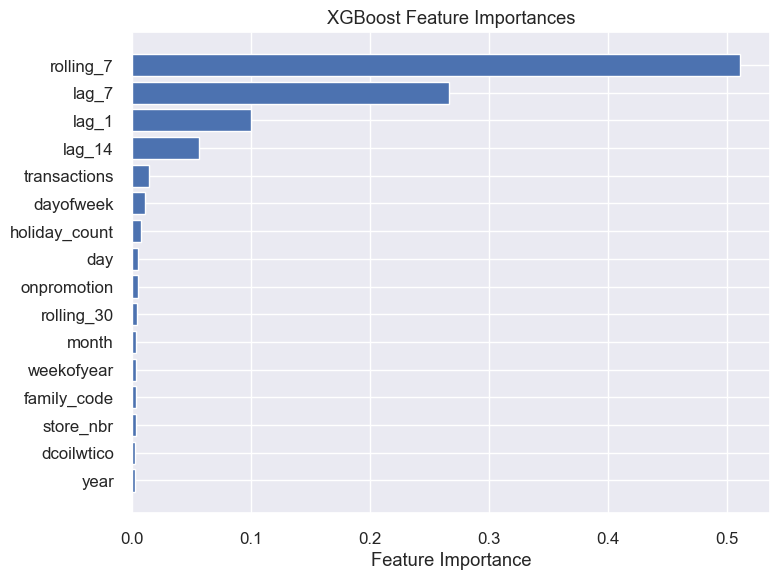

In [17]:
# --- XGBoost Feature Importance ---

xgb_importances = xgb.feature_importances_
indices = np.argsort(xgb_importances)[::-1]

sorted_features_xgb = [feature_cols[i] for i in indices]
sorted_importances_xgb = xgb_importances[indices]

plt.figure(figsize=(8, 6))
plt.barh(sorted_features_xgb[::-1], sorted_importances_xgb[::-1])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()





Epoch 1/50

21/21 [==============================] - 4s 69ms/step - loss: 0.0146 - val_loss: 0.0106
Epoch 2/50
21/21 [==============================] - 0s 21ms/step - loss: 0.0063 - val_loss: 0.0084
Epoch 3/50
21/21 [==============================] - 0s 22ms/step - loss: 0.0061 - val_loss: 0.0089
Epoch 4/50
21/21 [==============================] - 0s 21ms/step - loss: 0.0060 - val_loss: 0.0090
Epoch 5/50
21/21 [==============================] - 0s 20ms/step - loss: 0.0061 - val_loss: 0.0096
Epoch 6/50
21/21 [==============================] - 0s 17ms/step - loss: 0.0061 - val_loss: 0.0099
Epoch 7/50
11/11 [==============================] - 0s 4ms/step
LSTM performance on example series:
Validation – RMSE: 829.21, MAE: 603.11


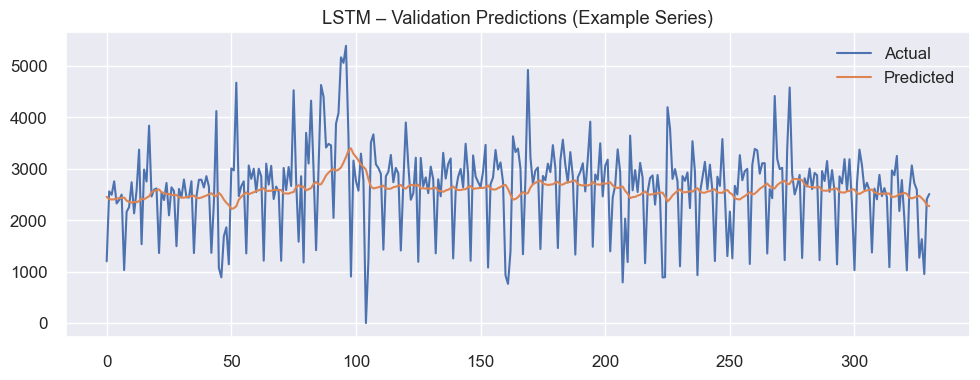

In [14]:
USE_LSTM = True  # set True to run this section

if USE_LSTM:
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from tensorflow.keras.callbacks import EarlyStopping

    # Use example series again, with lag-style supervised framing
    series_lstm = example[["date", "sales"]].set_index("date").copy()
    scaler = MinMaxScaler()
    series_lstm["sales_scaled"] = scaler.fit_transform(series_lstm[["sales"]])

    # Create sequences
    def create_sequences(data, window=30):
        X_seq, y_seq = [], []
        for i in range(len(data) - window):
            X_seq.append(data[i:i+window])
            y_seq.append(data[i+window])
        return np.array(X_seq), np.array(y_seq)

    values = series_lstm["sales_scaled"].values
    window_size = 30
    X_seq, y_seq = create_sequences(values, window=window_size)

    # Train/val split
    split_idx = int(len(X_seq) * 0.8)
    X_train_lstm, X_val_lstm = X_seq[:split_idx], X_seq[split_idx:]
    y_train_lstm, y_val_lstm = y_seq[:split_idx], y_seq[split_idx:]

    # Reshape for LSTM: (samples, timesteps, features)
    X_train_lstm = X_train_lstm.reshape((-1, window_size, 1))
    X_val_lstm = X_val_lstm.reshape((-1, window_size, 1))

    model_lstm = Sequential([
        LSTM(64, input_shape=(window_size, 1)),
        Dense(1)
    ])

    model_lstm.compile(optimizer="adam", loss="mse")

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = model_lstm.fit(
        X_train_lstm, y_train_lstm,
        validation_data=(X_val_lstm, y_val_lstm),
        epochs=50,
        batch_size=64,
        callbacks=[es],
        verbose=1
    )

    # Evaluate
    y_val_pred_scaled = model_lstm.predict(X_val_lstm).flatten()
    y_val_true_scaled = y_val_lstm

    # Inverse transform to original scale
    y_val_true = scaler.inverse_transform(y_val_true_scaled.reshape(-1,1)).flatten()
    y_val_pred = scaler.inverse_transform(y_val_pred_scaled.reshape(-1,1)).flatten()

    print("LSTM performance on example series:")
    print_metrics("Validation", y_val_true, y_val_pred)

    # Plot predictions vs actual
    plt.figure(figsize=(10,4))
    plt.plot(y_val_true, label="Actual")
    plt.plot(y_val_pred, label="Predicted")
    plt.title("LSTM – Validation Predictions (Example Series)")
    plt.legend()
    plt.tight_layout()
    plt.show()




In [15]:
print("Baseline Linear Regression performance:")
print_metrics("Validation", y_val, y_val_pred_lr)
print_metrics("Test", y_test, y_test_pred_lr)


Baseline Linear Regression performance:
Validation – RMSE: 336.58, MAE: 93.84
Test – RMSE: 244.72, MAE: 78.23


In [16]:
print("Random Forest performance:")
print_metrics("Validation", y_val, y_val_pred_rf)
print_metrics("Test", y_test, y_test_pred_rf)


Random Forest performance:
Validation – RMSE: 266.93, MAE: 64.65
Test – RMSE: 199.72, MAE: 56.03


In [17]:
print("XGBoost performance:")
print_metrics("Validation", y_val, y_val_pred_xgb)
print_metrics("Test", y_test, y_test_pred_xgb)


XGBoost performance:
Validation – RMSE: 259.15, MAE: 60.51
Test – RMSE: 187.15, MAE: 52.62


In [18]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def mpe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean((y_true[mask] - y_pred[mask]) / y_true[mask]) * 100


print("XGBoost MAPE:", mape(y_test, y_test_pred_xgb))
print("XGBoost MPE:", mpe(y_test, y_test_pred_xgb))


XGBoost MAPE: 37.28396813045971
XGBoost MPE: -12.920509407684563


In [20]:
# =====================================
# Build test_df for evaluation & plots
# =====================================

# Create a copy of df_fe for the test period only
test_df = df_fe.loc[test_mask].copy().reset_index(drop=True)

# Attach true and predicted values from the XGBoost model
test_df["y_true"] = y_test.values
test_df["y_pred_xgb"] = y_test_pred_xgb


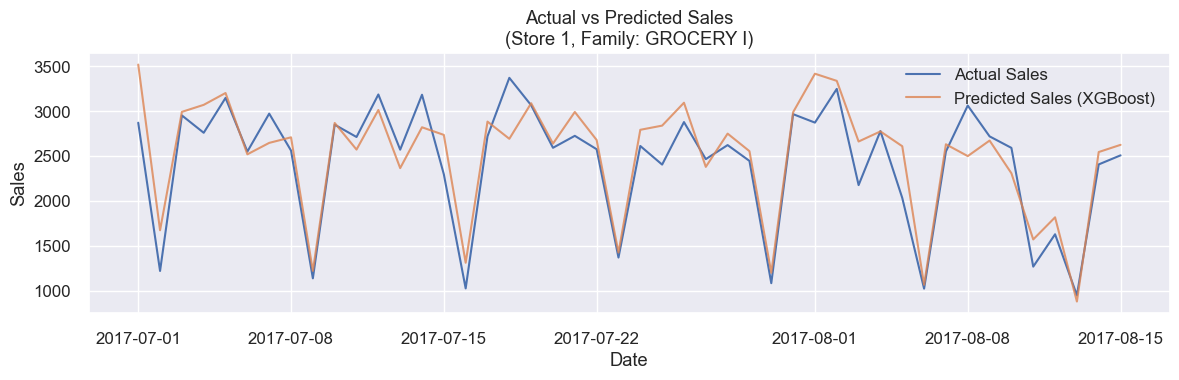

In [21]:
# =========================================
# Prediction vs Actual plot (XGBoost model)
# =========================================

# Reuse the test_df we built above
# test_df has: date, store_nbr, family, y_true, y_pred_xgb

example_store = 1
example_family = "GROCERY I"   # you can change this

plot_df = test_df[
    (test_df["store_nbr"] == example_store) &
    (test_df["family"] == example_family)
].copy()

plot_df = plot_df.sort_values("date")

plt.figure(figsize=(12, 4))
plt.plot(plot_df["date"], plot_df["y_true"], label="Actual Sales")
plt.plot(plot_df["date"], plot_df["y_pred_xgb"], label="Predicted Sales (XGBoost)", alpha=0.8)
plt.title(f"Actual vs Predicted Sales\n(Store {example_store}, Family: {example_family})")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# ===================================
# Utility: fetch a row from test_df
# ===================================

def get_feature_row(store_nbr, family, date):
    """
    Retrieves the engineered feature row from test_df
    for the given store, family, and date.
    """

    row = test_df[
        (test_df["store_nbr"] == store_nbr) &
        (test_df["family"] == family) &
        (test_df["date"] == date)
    ]

    if row.empty:
        return None
    return row[feature_cols]



In [23]:
def predict_sales(store, family, date_str):
    date = pd.to_datetime(date_str)

    X_row = get_feature_row(store, family, date)

    if X_row is None:
        return "No matching row found in test set. Try another date/store/family."

    pred = xgb.predict(X_row)[0]
    return pred


In [24]:
print(predict_sales(1, "GROCERY I", "2017-12-15"))


No matching row found in test set. Try another date/store/family.


In [25]:
def demo_prediction():
    row = test_df.iloc[0]
    store = int(row["store_nbr"])
    family = row["family"]
    date_str = row["date"].strftime("%Y-%m-%d")

    pred = predict_sales(store, family, date_str)
    print("Demo prediction:")
    print(f"Store:  {store}")
    print(f"Family: {family}")
    print(f"Date:   {date_str}")
    print(f"Predicted sales: {pred:.2f}")
    print(f"Actual sales:    {row['y_true']:.2f}")

demo_prediction()


Demo prediction:
Store:  1
Family: AUTOMOTIVE
Date:   2017-07-01
Predicted sales: 5.71
Actual sales:    7.00


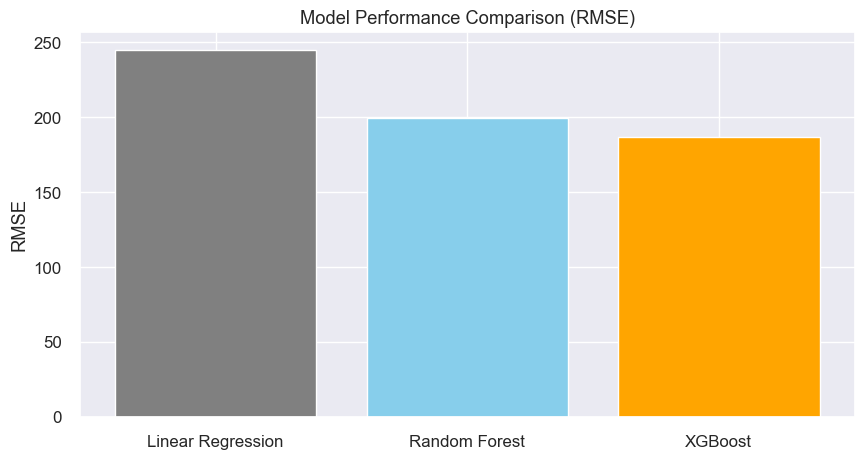

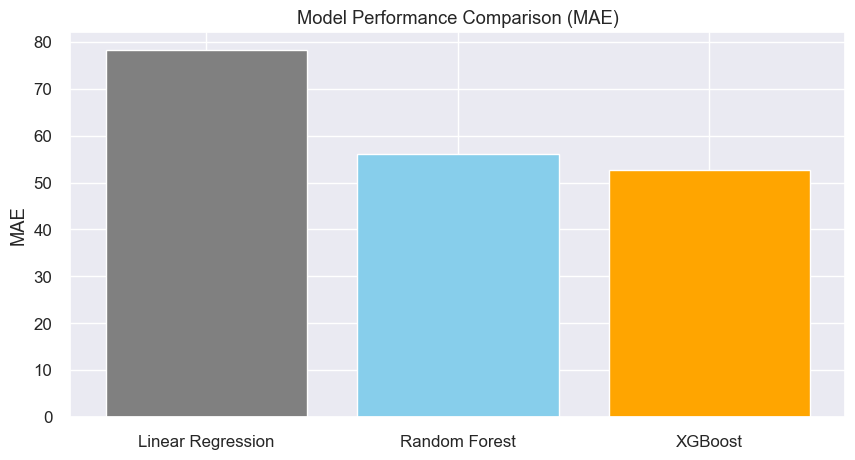

In [28]:
import matplotlib.pyplot as plt

models = ["Linear Regression", "Random Forest", "XGBoost"]
rmse_scores = [244.72, 199.72, 187.15]
mae_scores = [78.23, 56.03, 52.62]

plt.figure(figsize=(10,5))
plt.bar(models, rmse_scores, color=["gray","skyblue","orange"])
plt.title("Model Performance Comparison (RMSE)")
plt.ylabel("RMSE")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(models, mae_scores, color=["gray","skyblue","orange"])
plt.title("Model Performance Comparison (MAE)")
plt.ylabel("MAE")
plt.show()


In [29]:
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def mpe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean((y_true[mask] - y_pred[mask]) / y_true[mask]) * 100

# Compute for all models
mape_lr  = mape(y_test, y_test_pred_lr)
mape_rf  = mape(y_test, y_test_pred_rf)
mape_xgb = mape(y_test, y_test_pred_xgb)

mpe_lr  = mpe(y_test, y_test_pred_lr)
mpe_rf  = mpe(y_test, y_test_pred_rf)
mpe_xgb = mpe(y_test, y_test_pred_xgb)

print("MAPE  - LR, RF, XGB:", mape_lr, mape_rf, mape_xgb)
print("MPE   - LR, RF, XGB:", mpe_lr, mpe_rf, mpe_xgb)


MAPE  - LR, RF, XGB: 240.44735944952117 33.08130529728173 37.28396813045971
MPE   - LR, RF, XGB: 104.5125405493066 -14.132753102907591 -12.920509407684563


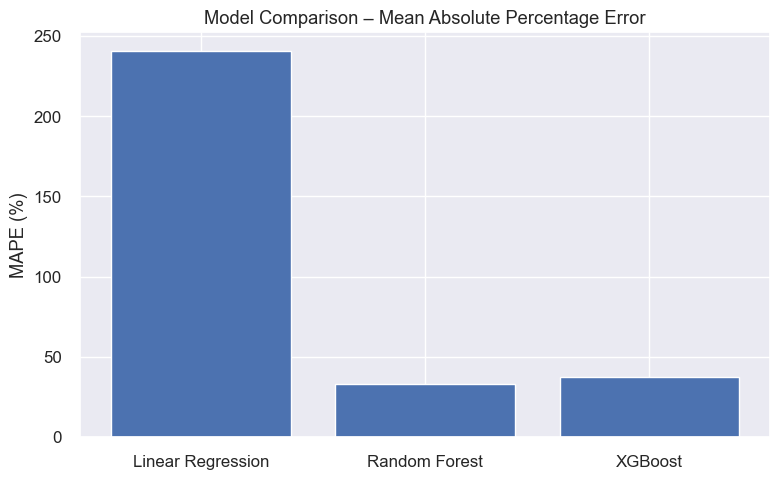

In [30]:
models = ["Linear Regression", "Random Forest", "XGBoost"]
mape_scores = [mape_lr, mape_rf, mape_xgb]

plt.figure(figsize=(8,5))
plt.bar(models, mape_scores)
plt.ylabel("MAPE (%)")
plt.title("Model Comparison – Mean Absolute Percentage Error")
plt.tight_layout()
plt.show()


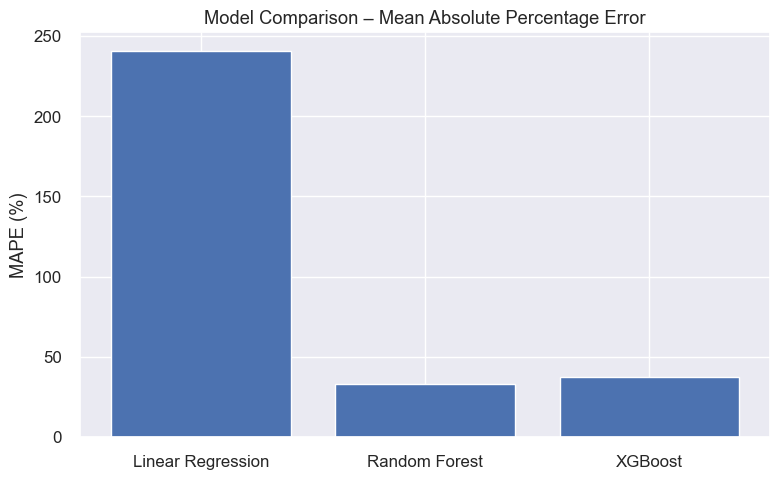

In [31]:
models = ["Linear Regression", "Random Forest", "XGBoost"]
mape_scores = [mape_lr, mape_rf, mape_xgb]

plt.figure(figsize=(8,5))
plt.bar(models, mape_scores)
plt.ylabel("MAPE (%)")
plt.title("Model Comparison – Mean Absolute Percentage Error")
plt.tight_layout()
plt.show()
